# Coursera Capstone - Weeks 4-5

## Start off by importing libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!pip install bs4 
!pip install lxml

#ALREADY INSTALLED FORGE USING ANACONDA PROMPT
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#ALREADY INSTALLED FOLIUM USING ANACONDA PROMPT
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 102kB 2.8MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 5.8MB 2.9MB/s eta 0:00:01
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                 

In [2]:
#web scraping using pandas
#note: set header = 0 to use the first row as column headers
# !pip install lxml to correct import error when reading html, lxml was not found
#!pip install html5lib #bandaid for lxml
!conda install -c conda-forge lxml --yes #-c conda-forge geopy --yes 
!conda install -c conda-forge html5lib --yes #-c conda-forge geopy --yes 

d = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)

#Interesting notes about the pandas list of tables that's created from reading the URL
#type(d) #prints 'list'
#print(len(d)) #prints '3' since there are 3 tables on this page. the one we want to use is index=0
#print(d[0]) #
#format of df['column_name']['row_#_in_column_name']

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    lxml-4.4.1                 |   py36h7ec2d77_0         1.6 MB  conda-forge

The following packages will be UPDATED:

    lxml: 4.2.5-py37hefd8a0e_0 --> 4.4.1-py36h7ec2d77_0 conda-forge


lxml-4.4.1           | 1.6 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ cond

### Extract the table from the URL as a Pandas dataframe (note the shape and column names)

In [3]:
#set the target table to a 'dataframe'
df = d[0]

#check the shape of df
print(len(df)) #prints '289' is the # of rows (including the column name row)
print(df.shape) #prints '(289, 3)'
print(df.columns) #prints 'Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')'

288
(288, 3)
Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')


#### Count the number of unassigned Boroughs

In [4]:
print("There are {} Boroughs that are 'Not Assigned.'".format(df[df.Borough == 'Not assigned']['Borough'].count()))

There are 77 Boroughs that are 'Not Assigned.'


### Remove rows in the Borough column that are 'Not assigned' (and view the results)

In [5]:
#remove Postcodes that are "Not Assigned"
#df = df.drop(df[df.score < 50].index)
df_del_na = df.drop(df[df.Borough == 'Not assigned'].index)
df_del_na.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Set Neighborhood from 'Not assigned' to "Queen's Park" (and view the results)

In [6]:
#set Neighborhood from 'Not assigned' to "Queen's Park"
df_del_na.loc[df_del_na['Neighbourhood'] == "Not assigned", 'Neighbourhood'] = "Queen's Park"
df_del_na.head(10)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


### Rename column name from 'Neighbourhood' to 'Neighborhood'

In [7]:
df_del_na.rename(columns={'Postcode': 'PostalCode', 'Neighbourhood': 'Neighborhood'}, inplace=True)
df_del_na.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Flatten the table (for the rows in the Neighborhood columns)

In [8]:
#flatten groupby results by setting Neighborhood to list per row
#ORIGINAL SCRIPT--->>>> df_del_na_grouped_flat = df_del_na.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda group_series: group_series.tolist()).reset_index()

df_del_na_grouped_flat = df_del_na.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index() #CHANGED SOLUTION TO EXAMPLE FROM ANOTHER STUDENT 
print(df_del_na_grouped_flat.head(10), '\n', '\n')
print(df_del_na_grouped_flat.tail(10))

  PostalCode      Borough                                     Neighborhood
0        M1B  Scarborough                                   Rouge, Malvern
1        M1C  Scarborough           Highland Creek, Rouge Hill, Port Union
2        M1E  Scarborough                Guildwood, Morningside, West Hill
3        M1G  Scarborough                                           Woburn
4        M1H  Scarborough                                        Cedarbrae
5        M1J  Scarborough                              Scarborough Village
6        M1K  Scarborough      East Birchmount Park, Ionview, Kennedy Park
7        M1L  Scarborough                  Clairlea, Golden Mile, Oakridge
8        M1M  Scarborough  Cliffcrest, Cliffside, Scarborough Village West
9        M1N  Scarborough                      Birch Cliff, Cliffside West 
 

    PostalCode     Borough                                       Neighborhood
93         M9A   Etobicoke                                   Islington Avenue
94         M9B 

### Read the csv into a pandas dataframe

In [9]:
geofile = pd.read_csv('https://cocl.us/Geospatial_data')

### Rename the Postal Code column to PostalCode

In [10]:
geofile.rename(columns = {'Postal Code': 'PostalCode'}, inplace=True)

### Merge the two dataframes

In [11]:
df_combined = pd.merge(df_del_na_grouped_flat, geofile, how='left', on='PostalCode')

### View the merged dataframe

In [12]:
df_combined.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [13]:
#len(df_combined['PostalCode'].unique()) #to check for unique postal codes...matches 103 of shape
df_combined.shape

(103, 5)

In [14]:
print('There are {} unique Postal Codes.'.format(df_combined.shape[0]))

There are 103 unique Postal Codes.


### Plot the Neighborhoods

In [15]:
#Use a starting latitude and longitude to help center the Toronto area map:
latitude = 43.72
longitude = -79.4
venues_map = folium.Map(location=[latitude, longitude], zoom_start=11.5) # generate map centred around the Conrad Hotel

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_combined.Latitude, df_combined.Longitude, df_combined.PostalCode):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

#### Define Foursquare ID and Secret (hidden for GIT post)

In [16]:
CLIENT_ID = 'HBIWSY1J1OXYRJV3GRFGMHIKD25MSPBZJSDBWVVQBEWM1YGB' # your Foursquare ID
CLIENT_SECRET = 'UBNOMB4NFKZWJU21DBEDHRHPFZEFNSPMK0RT2YFOV4DDN4BL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HBIWSY1J1OXYRJV3GRFGMHIKD25MSPBZJSDBWVVQBEWM1YGB
CLIENT_SECRET:UBNOMB4NFKZWJU21DBEDHRHPFZEFNSPMK0RT2YFOV4DDN4BL


#### Define Foursquare Credentials and Version

In [17]:
def getNearbyVenues(postalcodes, names, latitudes, longitudes, radius=500, LIMIT=100): #added ratings
    
    venues_list=[]
    for postalcode, name, lat, lng in zip(postalcodes, names, latitudes, longitudes): #added ratings
        print(name)
            
        # create the API request URL #need to add ratings query to this url request
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,            
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Use the function that explores nearby venues

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [20]:
toronto_venues = getNearbyVenues(postalcodes=df_combined['PostalCode'],
                                 names=df_combined['Neighborhood'],
                                   latitudes=df_combined['Latitude'],
                                   longitudes=df_combined['Longitude']
                                  )



Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

#### Let's peek at sample rows and the shape of the Toronto venues dataframe

In [21]:
toronto_venues.sample(10)

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1115,M5H,"Adelaide, King, Richmond",43.650571,-79.384568,Pi Co.,43.648651,-79.385874,Pizza Place
1836,M5X,"First Canadian Place, Underground city",43.648429,-79.382280,deKEFIR,43.650433,-79.379393,Ice Cream Shop
323,M4G,Leaside,43.709060,-79.363452,Sport Chek,43.709854,-79.360455,Sporting Goods Shop
264,M3L,Downsview West,43.739015,-79.506944,jane sheppard mall,43.740104,-79.512552,Shopping Mall
1007,M5G,Central Bay Street,43.657952,-79.387383,Banh Mi Boys,43.659292,-79.381949,Sandwich Place
147,M2J,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Manchu Wok,43.778225,-79.343302,Chinese Restaurant
2173,M8V,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,LCBO,43.602281,-79.499302,Liquor Store
1143,M5H,"Adelaide, King, Richmond",43.650571,-79.384568,Lavish & Squalor,43.650304,-79.388927,Clothing Store
133,M2J,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Nike,43.777745,-79.344500,Sporting Goods Shop
630,M4Y,Church and Wellesley,43.665860,-79.383160,Holy Chuck,43.665241,-79.384728,Burger Joint


In [22]:
toronto_venues.shape

(2255, 8)

In [23]:
#export combined dataframe to excel (optional)
#!conda install -c conda-forge openpyxl --yes

#toronto_venues.to_excel("toronto_venues.xlsx")

#### Add the assigned scores by category

In [24]:
!conda install -c conda-forge xlrd --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - xlrd


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    xlrd-1.2.0                 |             py_0         108 KB  conda-forge

The following packages will be UPDATED:

    xlrd: 1.1.0-py37_1 --> 1.2.0-py_0 conda-forge


xlrd-1.2.0           | 108 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


#### Sample the types of categories and print the total venue categories in the Toronta area

In [25]:
#reset index?
df_toronto = pd.DataFrame(toronto_venues.groupby('Venue Category')['Venue Category'].count()) #count() :['count'] #agg({'Count':['count']})
df_toronto.rename(columns={'Venue Category': 'Count'}, inplace=True)
df_toronto.sample(10)

,Count
Venue Category,
Malay Restaurant,1
Concert Hall,10
Lounge,14
Airport Service,3
Ethiopian Restaurant,2
Wine Bar,10
River,1
Accessories Store,1
Art Museum,2


In [26]:
print("There are {} categories of venues in the Toronto area, across {} unique Postal Codes.".format(df_toronto.shape[0], df_combined.shape[0]))

There are 274 categories of venues in the Toronto area, across 103 unique Postal Codes.


#### Let's look at a table of the categories in the Toronto area.

In [27]:
#create a bar plot of categories
#PLOT IS KIND OF MESSY...FILTER BY COUNTS...also consider plotting using a loop
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

df_toronto.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Category Counts in the Toronto Area') # add title to the plot

plt.show()

<Figure size 1000x600 with 1 Axes>

#### This plot looks kinda messy. Let's plot categories for only the Postal Codes with the highest scores.

#### Read the scoring system (given by the Company) into a pandas dataframe

In [28]:
cat_scores = pd.read_excel('toronto_venues_scores_only.xlsx')

In [29]:
cat_scores.head()

,Category,Score
0,Accessories Store,0
1,Afghan Restaurant,1
2,Airport,100
3,Airport Food Court,0
4,Airport Gate,0


#### Using the scoring system provided by the Company, find total score for each Postal Code

In [30]:
#merge scoring df with toronto_venues df
df_scores = pd.merge(toronto_venues[['PostalCode', 'Venue Category']], cat_scores, how='left', left_on='Venue Category', right_on='Category')
df_scores.head()

,PostalCode,Venue Category,Category,Score
0,M1B,Fast Food Restaurant,Fast Food Restaurant,1.0
1,M1C,Bar,Bar,2.0
2,M1E,Pizza Place,Pizza Place,1.0
3,M1E,Electronics Store,Electronics Store,1.0
4,M1E,Mexican Restaurant,Mexican Restaurant,2.0


In [31]:
#use groupby to sum scores for each postal code
df_scores_gb = pd.DataFrame(df_scores.groupby('PostalCode')['Score'].sum()).reset_index() #added reset_index()
df_scores_gb.head()

,PostalCode,Score
0,M1B,1.0
1,M1C,2.0
2,M1E,12.0
3,M1G,3.0
4,M1H,11.0


#### Look at the Postal Codes in top 20 (then create df of top 20...and the top five)

In [32]:
df_scores_gb_sorted = df_scores_gb.sort_values('Score', ascending=False)
df_scores_gb_sorted.head(20)

,PostalCode,Score
57,M5J,287.0
58,M5K,197.0
68,M5X,182.0
56,M5H,178.0
67,M5W,174.0
59,M5L,174.0
53,M5C,154.0
52,M5B,130.0
65,M5T,123.0
50,M4Y,120.0


In [33]:
df_scores_gb_sorted_top20 = df_scores_gb_sorted.head(20)
df_scores_gb_sorted_top20

,PostalCode,Score
57,M5J,287.0
58,M5K,197.0
68,M5X,182.0
56,M5H,178.0
67,M5W,174.0
59,M5L,174.0
53,M5C,154.0
52,M5B,130.0
65,M5T,123.0
50,M4Y,120.0


In [34]:
df_scores_gb_sorted_top5 = df_scores_gb_sorted.head(5)
df_scores_gb_sorted_top5

,PostalCode,Score
57,M5J,287.0
58,M5K,197.0
68,M5X,182.0
56,M5H,178.0
67,M5W,174.0


In [35]:
#TEST - DELETE AFTER TEST
type(df_scores_gb_sorted_top5.shape[0])

int

In [36]:
df_scores_gb_sorted_top5.PostalCode.values

array(['M5J', 'M5K', 'M5X', 'M5H', 'M5W'], dtype=object)

In [37]:
top5_list = df_scores_gb_sorted_top5.PostalCode.values
top5_list

array(['M5J', 'M5K', 'M5X', 'M5H', 'M5W'], dtype=object)

In [38]:
#TEST - DELETE WHEN DONE
top5_list_test = list(df_scores_gb_sorted_top5.PostalCode.values)
top5_list_test[0]

'M5J'

#### Plot the scores for the top 20 (and top five) Postal Codes

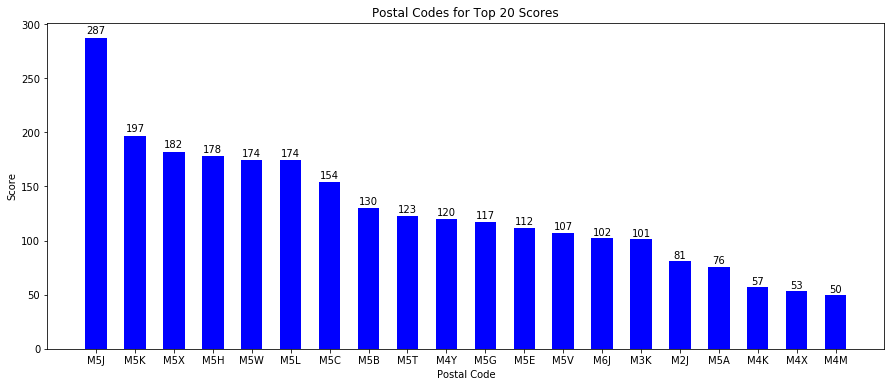

In [39]:
"""
========
Barchart - Top 20
========

A bar plot with height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt

N = df_scores_gb_sorted_top20.shape[0] # or use: len(list(df_scores_gb_sorted_top20.PostalCode.values))
ind = np.arange(N)  # the x locations for the groups
width = 0.55       # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6)) #set figure size inside subplots
rects1 = ax.bar(ind, df_scores_gb_sorted_top20.Score.values, width, color='b') #, figsize=(10, 6)


# add some text for labels, title and axes ticks
ax.set_ylabel('Score')
ax.set_xlabel('Postal Code')
ax.set_title('Postal Codes for Top 20 Scores')
ax.set_xticks(ind) #ind + width / 2 for 2nd bar when plotting two bar subplots
ax.set_xticklabels(df_scores_gb_sorted_top20.PostalCode.values) # set x-axis labels using the Postal Code column values
#NEED TO SET LEGEND
#ax.legend() # rects1[0], 'Score' # rects1[0], ('Postal Code')


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, #1.05*height,
        '%d' % int(height),
        ha='center', va='bottom')

autolabel(rects1)

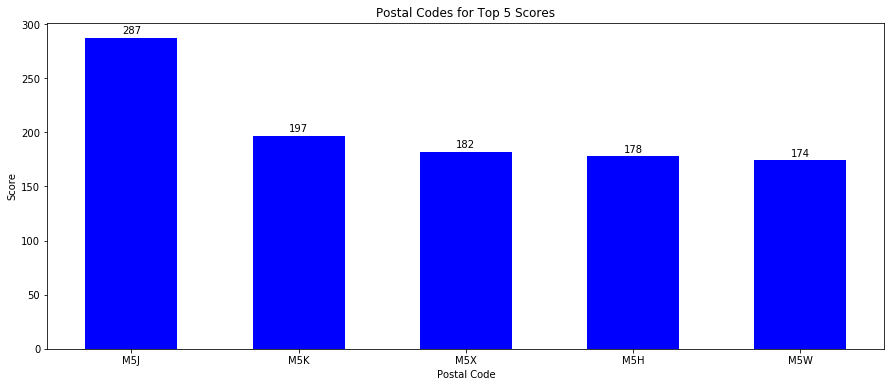

In [40]:
#NEED TO SET LEGEND
#ax.legend() # rects1[0], 'Score' # rects1[0], ('Postal Code')
"""
========
Barchart - Top 5
========

A bar plot with height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt

N = df_scores_gb_sorted_top5.shape[0] # or use: len(list(df_scores_gb_sorted_top20.PostalCode.values))
ind = np.arange(N)  # the x locations for the groups
width = 0.55       # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6)) #set figure size inside subplots
rects1 = ax.bar(ind, df_scores_gb_sorted_top5.Score.values, width, color='b') #, figsize=(10, 6)


# add some text for labels, title and axes ticks
ax.set_ylabel('Score')
ax.set_xlabel('Postal Code')
ax.set_title('Postal Codes for Top 5 Scores')
ax.set_xticks(ind) #ind + width / 2 for 2nd bar when plotting two bar subplots
ax.set_xticklabels(df_scores_gb_sorted_top5.PostalCode.values) # set x-axis labels using the Postal Code column values


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, #1.05*height,
        '%d' % int(height),
        ha='center', va='bottom')

autolabel(rects1)

In [41]:
#OLD/QUICK WAY TO CREATE BAR PLOT (WITHOUT ENCHANCEMENTS TO TOTALS ABOVE BAR PLOT)
#create a bar plot of categories and scores
#from sklearn.cluster import KMeans
#import matplotlib.pyplot as plt 

#df_scores_gb_sorted_top20.plot(kind='bar', x='PostalCode', figsize=(10, 6))


#plt.xlabel('Postal Code') # add to x-label to the plot
#plt.ylabel('Score') # add y-label to the plot
#plt.title('Scores of Top 20 Postal Codes') # add title to the plot

#plt.show()


In [42]:
#GROUPBY WORK TO ADD POSTAL CODES, CATEGORY COUNTS
jb_junk = pd.DataFrame(toronto_venues.groupby('Venue Category')['Venue Category'].count())

In [43]:
#df_toronto.index

In [44]:
#df_toronto.loc[df['Count'] > 50]

In [45]:
#create a bar plot of categories
#df_toronto.plot(kind='bar', figsize=(10, 6))

#plt.xlabel('Venue Category') # add to x-label to the plot
#plt.ylabel('Number of Venues') # add y-label to the plot
#plt.title('Category Counts in the Toronto Area') # add title to the plot

#plt.show()

#for i in range(1, len(df_toronto['Count'])):
#    print('Row {}, {}'.format(i, df_toronto.loc['Count'][i]))

#### Start with one hot encoding

In [46]:
# one hot encoding
toronto_venues_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add latitudes for both Neighborhoods and Venues back to dataframe - for adding lat, long later
#toronto_venues_onehot_lat-lon[['Neighborhood Latitude', 'Neighborhood Longitude']] = toronto_venues[['Neighborhood Latitude', 'Neighborhood Longitude']]
#toronto_venues_onehot_lat-lon[['Venue Latitude', 'Venue Longitude']] = toronto_venues[['Venue Latitude', 'Venue Longitude']]

# add PostalCode column back to dataframe
toronto_venues_onehot['PostalCode'] = toronto_venues['PostalCode'] 

# move postal code column to the first column
fixed_columns = [toronto_venues_onehot.columns[-1]] + list(toronto_venues_onehot.columns[:-1])
toronto_venues_onehot = toronto_venues_onehot[fixed_columns]

toronto_venues_onehot.head()

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [47]:
toronto_venues_onehot.shape

(2255, 275)

~~REMOVE THIS FOR FINAL VERSION *** EITHER SCALE LAT, LON OR REMOVE LAT, LON ALTOGETHER~~

In [48]:
#toronto_venues_onehot_grouped_temp = toronto_venues_onehot.groupby('PostalCode').mean().reset_index()
#toronto_venues_onehot_grouped_temp.head(5)

~~REMOVE THIS FOR FINAL VERSION 
Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms interpret features with different magnitudes and distributions equally. We use **StandardScaler()** to normalize our dataset.~~

In [49]:
#MIGHT NOT HAVE TO SCALE SINCE AVERAGES - THIS IS FROM 3-3-1
#from sklearn.preprocessing import StandardScaler

#add step to remove postalcode
#X = toronto_venues_onehot_grouped_temp.values[:,1:] #<-Change df name to toronto_venues_onehot or toronto_venues
#X = np.nan_to_num(X)
#toronto_venues_onehot_grouped_temp_scale = StandardScaler().fit_transform(X)
#toronto_venues_onehot_grouped_temp_scale

#### Next, let's group rows by Postal Code and by taking the mean of the frequency of occurrence of each category

In [50]:
toronto_venues_onehot_grouped = toronto_venues_onehot.groupby('PostalCode').mean().reset_index()
toronto_venues_onehot_grouped.sample(5)

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
67,M5W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010309,0.0,0

#### Let's confirm the new size

In [51]:
toronto_venues_onehot_grouped.shape

(100, 275)

In [52]:
toronto_venues_onehot_grouped['PostalCode'].unique()

array(['M1B', 'M1C', 'M1E', 'M1G', 'M1H', 'M1J', 'M1K', 'M1L', 'M1M',
       'M1N', 'M1P', 'M1R', 'M1S', 'M1T', 'M1V', 'M1W', 'M2H', 'M2J',
       'M2K', 'M2L', 'M2N', 'M2P', 'M2R', 'M3A', 'M3B', 'M3C', 'M3H',
       'M3J', 'M3K', 'M3L', 'M3M', 'M3N', 'M4A', 'M4B', 'M4C', 'M4E',
       'M4G', 'M4H', 'M4J', 'M4K', 'M4L', 'M4M', 'M4N', 'M4P', 'M4R',
       'M4S', 'M4T', 'M4V', 'M4W', 'M4X', 'M4Y', 'M5A', 'M5B', 'M5C',
       'M5E', 'M5G', 'M5H', 'M5J', 'M5K', 'M5L', 'M5M', 'M5N', 'M5P',
       'M5R', 'M5S', 'M5T', 'M5V', 'M5W', 'M5X', 'M6A', 'M6B', 'M6C',
       'M6E', 'M6G', 'M6H', 'M6J', 'M6K', 'M6L', 'M6M', 'M6N', 'M6P',
       'M6R', 'M6S', 'M7A', 'M7R', 'M7Y', 'M8V', 'M8W', 'M8X', 'M8Y',
       'M8Z', 'M9B', 'M9C', 'M9L', 'M9M', 'M9N', 'M9P', 'M9R', 'M9V',
       'M9W'], dtype=object)

In [53]:
toronto_venues_onehot_grouped['PostalCode'].nunique()

100

#### Now that we've completed the onehot transformation, let's continue with  k-means for all venues

#### Remove categorical columns 
Before we start our k-means clustering analysis, we have to remove categorical columns (non-numeric columns).

In [54]:
toronto_venues_onehot_grouped_clustering = toronto_venues_onehot_grouped.drop('PostalCode', 1)

In [55]:
toronto_venues_onehot_grouped_clustering.shape

(100, 274)

#### "Elbow" Plot Analysis
The Elbow method analyzes the number of k-means clusters (k) by plotting and examining the sum of squared distances from the cluster center (SSD) for a given number of clusters (k). When plotted, we can visually identify the optimal number of clusters, which should clearly show a point on the graph where reduction in SSE diminishes for increases in k. This point is referred to as the "elbow."

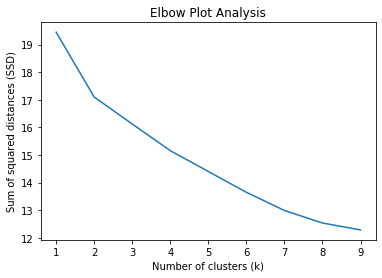

In [56]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

ssd = {}
for k in range(1, 10):
    kmeans_elbow = KMeans(n_clusters=k, max_iter=1000).fit(toronto_venues_onehot_grouped_clustering)
    toronto_venues_onehot_grouped_clustering["clusters"] = kmeans_elbow.labels_
    #print(toronto_venues_onehot_grouped_clustering["clusters"])
    ssd[k] = kmeans_elbow.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure() #.pyplot
plt.plot(list(ssd.keys()), list(ssd.values()))
plt.title("Elbow Plot Analysis")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of squared distances (SSD)")
plt.show()

#### In the figure above, the optimal number number of clusters, k, is 2

In [57]:
# set number of clusters based on the elbow plot
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_venues_onehot_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:] #commented this one out until get len of rows (probably from shape)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0], dtype=int32)

In [58]:
#add labels column to toronto dataframe
labels = kmeans.labels_
toronto_venues_onehot_grouped['Cluster Labels'] = labels
toronto_venues_onehot_grouped.head()

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Cluster Labels
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [59]:
toronto_venues_onehot_grouped.shape

(100, 276)

In [60]:
# refresh my memory on columuns/structure of toronto_venues
toronto_venues.head()

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,M1C,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [61]:
#groupby toronto venues to later add latitudes, longitudes to onehot dataframe
toronto_venues.groupby('PostalCode').mean().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude
PostalCode,,,,
M1B,43.806686,-79.194353,43.807448,-79.199056
M1C,43.784535,-79.160497,43.782533,-79.163085
M1E,43.763573,-79.188711,43.766502,-79.191117
M1G,43.770992,-79.216917,43.770559,-79.219579
M1H,43.773136,-79.239476,43.774893,-79.240162


In [62]:
#confirm the shape / number of rows for PostalCode join
toronto_venues.groupby('PostalCode').mean().shape

(100, 4)

In [63]:
#add kmeans labels to grouped toronto labels...STILL RESET INDEX INPLACE?
df_temp = toronto_venues.groupby(['PostalCode', 'Neighborhood']).mean().reset_index() 

In [64]:
type(df_temp) #DataFrame check. reset_index removes df type?? #DELETE THIS CELL AFTER TEST WORKS

pandas.core.frame.DataFrame

In [65]:
df_temp.head()

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude
0,M1B,"Rouge, Malvern",43.806686,-79.194353,43.807448,-79.199056
1,M1C,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,43.782533,-79.163085
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,43.766502,-79.191117
3,M1G,Woburn,43.770992,-79.216917,43.770559,-79.219579
4,M1H,Cedarbrae,43.773136,-79.239476,43.774893,-79.240162


In [66]:
df_labels_temp = toronto_venues_onehot_grouped[['PostalCode', 'Cluster Labels']] #, 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'

In [67]:
df_labels_temp.head()

,PostalCode,Cluster Labels
0,M1B,0
1,M1C,0
2,M1E,0
3,M1G,0
4,M1H,0


In [68]:
toronto_venues_groupby_AddKmeansLabels = pd.merge(df_temp, df_labels_temp, how='left', on='PostalCode') #.reset.index(inplace=True) #CHECK MERGE METHOD...NEIGHBORHOOD STILL LEFT OFF (BETTER THAN ERROR THIS TIME)

In [69]:
toronto_venues_groupby_AddKmeansLabels.head()

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Cluster Labels
0,M1B,"Rouge, Malvern",43.806686,-79.194353,43.807448,-79.199056,0
1,M1C,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,43.782533,-79.163085,0
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,43.766502,-79.191117,0
3,M1G,Woburn,43.770992,-79.216917,43.770559,-79.219579,0
4,M1H,Cedarbrae,43.773136,-79.239476,43.774893,-79.240162,0


#### Now that we've added the k-means cluster labels, let's perform a groupby query by the **_Cluster Labels_** column

In [70]:
toronto_venues_groupby_AddKmeansLabels.groupby(['Cluster Labels', 'Neighborhood']).mean()

Neighborhood Latitude  \
Cluster Labels Neighborhood                                                                
0              Adelaide, King, Richmond                                        43.650571   
               Agincourt                                                       43.794200   
               Albion Gardens, Beaumond Heights, Humbergate, J...              43.739416   
               Alderwood, Long Branch                                          43.602414   
               Bathurst Manor, Downsview North, Wilson Heights                 43.754328   
               Bayview Village                                                 43.786947   
               Bedford Park, Lawrence Manor East                               43.733282   
               Berczy Park                                                     43.644771   
               Birch Cliff, Cliffside West                                     43.692657   
               Bloordale Gardens, Eringate, Markland Wood, Old...              43.643515   
               Brockton, Exhibition Place, Parkdale Village                    43.636847   
               Business Reply Mail Processing Centre 969 Eastern               43.662744   
               CN Tower, Bathurst Quay, Island airport, Harbou...              43.628947   
               Cabbagetown, St. James Town                                     43.667967   
               Canada Post Gateway Processing Centre                           43.636966   
               Cedarbrae                                                       43.773136   
               Central Bay Street                                              43.657952   
               Chinatown, Grange Park, Kensington Market                       43.653206   
               Christie                                                        43.669542   
               Church and Wellesley                                            43.665860   
               Clairlea, Golden Mile, Oakridge                                 43.711112   
               Clarks Corners, Sullivan, Tam O'Shanter                         43.781637   
               Cliffcrest, Cliffside, Scarborough Village West                 43.716316   
               Cloverdale, Islington, Martin Grove, Princess G...              43.650943   
               Commerce Court, Victoria Hotel                                  43.648199   
               Davisville                                                      43.704324   
               Davisville North                                                43.712751   
               Deer Park, Forest Hill SE, Rathnelly, South Hil...              43.686412   
               Del Ray, Keelesdale, Mount Dennis, Silverthorn                  43.691116   
               Design Exchange, Toronto Dominion Centre                        43.647177   
               Don Mills North                                                 43.745906   
               Dorset Park, Scarborough Town Centre, Wexford H...              43.757410   
               Dovercourt Village, Dufferin                                    43.669005   
               Downsview Northwest                                             43.761631   
               Downsview West                                                  43.739015   
               East Birchmount Park, Ionview, Kennedy Park                     43.727929   
               Fairview, Henry Farm, Oriole                                    43.778517   
               First Canadian Place, Underground city                          43.648429   
               Flemingdon Park, Don Mills South                                43.725900   
               Glencairn                                                       43.709577   
               Guildwood, Morningside, West Hill                               43.763573   
               Harbord, University of Toronto                                  43.662696   
               Harb

#### Visualize the Clusters (inserted from lesson 3-3-2)

In [71]:
# create map
latitude = 43.72
longitude = -79.4

map_clusters_2 = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters) #kclusters already identified during the "elbow" analysis
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_venues_groupby_AddKmeansLabels['Neighborhood Latitude'], toronto_venues_groupby_AddKmeansLabels['Neighborhood Longitude'], toronto_venues_groupby_AddKmeansLabels['PostalCode'], toronto_venues_groupby_AddKmeansLabels['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_2)
       
map_clusters_2

In [72]:
#pd.merge(toronto_venues[['PostalCode', 'Venue Category']], cat_scores, how='left', left_on='Venue Category', right_on='Category')
#df_labels_temp
df_toronto_venues_labeled = pd.merge(toronto_venues, df_labels_temp, on='PostalCode')
df_toronto_venues_labeled.head()

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,M1B,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant,0
1,M1C,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar,0
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place,0
3,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store,0
4,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant,0


In [73]:
#add scores
df_toronto_venues_labeled2 = pd.merge(df_toronto_venues_labeled, cat_scores, how='left', left_on='Venue Category', right_on='Category')
df_toronto_venues_labeled2.head()

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Category,Score
0,M1B,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant,0,Fast Food Restaurant,1.0
1,M1C,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar,0,Bar,2.0
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place,0,Pizza Place,1.0
3,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store,0,Electronics Store,1.0
4,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant,0,Mexican Restaurant,2.0


In [74]:
df_top5 = df_toronto_venues_labeled2[df_toronto_venues_labeled2.PostalCode.isin(top5_list)].reset_index()
df_top5.head()

,index,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Category,Score
0,1079,M5H,"Adelaide, King, Richmond",43.650571,-79.384568,Four Seasons Centre for the Performing Arts,43.650592,-79.385806,Concert Hall,0,Concert Hall,5.0
1,1080,M5H,"Adelaide, King, Richmond",43.650571,-79.384568,The Keg Steakhouse & Bar,43.649937,-79.384196,Steakhouse,0,Steakhouse,1.0
2,1081,M5H,"Adelaide, King, Richmond",43.650571,-79.384568,Nathan Phillips Square,43.652270,-79.383516,Plaza,0,Plaza,1.0
3,1082,M5H,"Adelaide, King, Richmond",43.650571,-79.384568,Rosalinda,43.650252,-79.385156,Vegetarian / Vegan Restaurant,0,Vegetarian / Vegan Restaurant,1.0
4,1083,M5H,"Adelaide, King, Richmond",43.650571,-79.384568,Shangri-La Toronto,43.649129,-79.386557,Hotel,0,Hotel,5.0


In [75]:
df_top5.shape

(497, 12)

#### Plot Category Scores for the top 5 Postal Codes

M5J

In [76]:
#plot
chk = df_top5.loc[df_top5['PostalCode'] == top5_list[0]]
chk_gb0 = chk.groupby(['PostalCode', 'Category'])['Score'].sum() #.sort_values('Score', ascending=False)
chk_gb0.head() #this is a series - pandas.core.series.Series

PostalCode  Category        
M5J         Aquarium            50.0
            Art Gallery         10.0
            Bakery               2.0
            Bar                  4.0
            Baseball Stadium    50.0
Name: Score, dtype: float64

In [77]:
chk_gb0.sort_values(ascending=False, inplace=True)
chk_gb0.head()

PostalCode  Category          
M5J         Aquarium              50.0
            Baseball Stadium      50.0
            Hotel                 25.0
            Basketball Stadium    25.0
            Scenic Lookout        15.0
Name: Score, dtype: float64

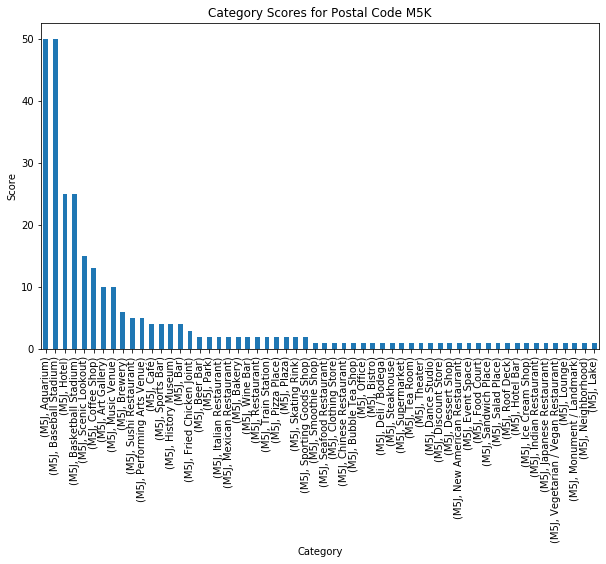

In [78]:
#create a bar plot of categories and scores
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

chk_gb0.plot(kind='bar', x='Category', figsize=(10, 6))

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Score') # add y-label to the plot
plt.title('Category Scores for Postal Code M5K') # add title to the plot

plt.show()

M5K

In [79]:
#plot
chk = df_top5.loc[df_top5['PostalCode'] == top5_list[1]]
chk_gb1 = chk.groupby(['PostalCode', 'Category'])['Score'].sum() #.sort_values('Score', ascending=False)
chk_gb1.head() #this is a series - pandas.core.series.Series

PostalCode  Category           
M5K         American Restaurant    15.0
            Art Gallery            10.0
            Asian Restaurant        5.0
            Bakery                  3.0
            Bar                     6.0
Name: Score, dtype: float64

In [80]:
chk_gb1.sort_values(ascending=False, inplace=True)
chk_gb1.head()

PostalCode  Category           
M5K         Hotel                  30.0
            Basketball Stadium     25.0
            American Restaurant    15.0
            Coffee Shop            12.0
            Art Gallery            10.0
Name: Score, dtype: float64

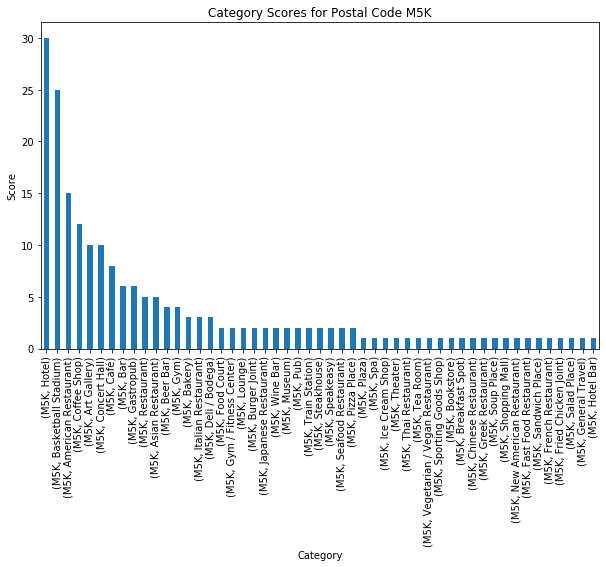

In [81]:
#create a bar plot of categories and scores
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

chk_gb1.plot(kind='bar', x='Category', figsize=(10, 6))

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Score') # add y-label to the plot
plt.title('Category Scores for Postal Code M5K') # add title to the plot

plt.show()

M5X

In [82]:
#plot
chk = df_top5.loc[df_top5['PostalCode'] == top5_list[2]]
chk_gb2 = chk.groupby(['PostalCode', 'Category'])['Score'].sum() #.sort_values('Score', ascending=False)
chk_gb2 #this is a series - pandas.core.series.Series

PostalCode  Category                     
M5X         American Restaurant              15.0
            Art Gallery                      10.0
            Asian Restaurant                 15.0
            Bakery                            2.0
            Bar                               6.0
            Beer Bar                          4.0
            Bookstore                         1.0
            Brazilian Restaurant              1.0
            Burger Joint                      3.0
            Burrito Place                     1.0
            Café                              8.0
            Coffee Shop                       9.0
            Colombian Restaurant              1.0
            Concert Hall                     10.0
            Deli / Bodega                     3.0
            Department Store                  1.0
            Food Court                        1.0
            Fried Chicken Joint               1.0
            Gastropub                         6.0
        

In [83]:
chk_gb2.sort_values(ascending=False, inplace=True)
chk_gb2.head()

PostalCode  Category           
M5X         Hotel                  25.0
            American Restaurant    15.0
            Asian Restaurant       15.0
            Art Gallery            10.0
            Concert Hall           10.0
Name: Score, dtype: float64

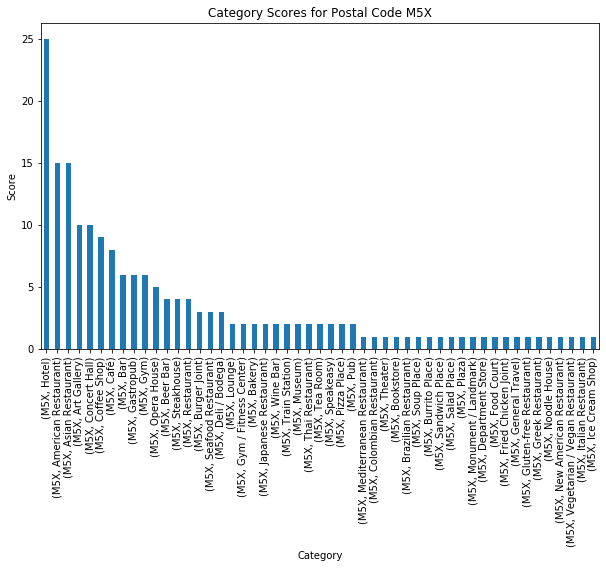

In [84]:
#create a bar plot of categories and scores
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

chk_gb2.plot(kind='bar', x='Category', figsize=(10, 6))

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Score') # add y-label to the plot
plt.title('Category Scores for Postal Code M5X') # add title to the plot

plt.show()

M5H

In [85]:
#plot
chk = df_top5.loc[df_top5['PostalCode'] == top5_list[3]]
chk_gb3 = chk.groupby(['PostalCode', 'Category'])['Score'].sum() #.sort_values('Score', ascending=False)
chk_gb3.head() #this is a series - pandas.core.series.Series

PostalCode  Category           
M5H         American Restaurant    15.0
            Art Gallery            10.0
            Art Museum             10.0
            Asian Restaurant       10.0
            Bakery                  2.0
Name: Score, dtype: float64

In [86]:
chk_gb3.sort_values(ascending=False, inplace=True)
chk_gb3.head()

PostalCode  Category           
M5H         Hotel                  15.0
            American Restaurant    15.0
            Sushi Restaurant       10.0
            Art Gallery            10.0
            Art Museum             10.0
Name: Score, dtype: float64

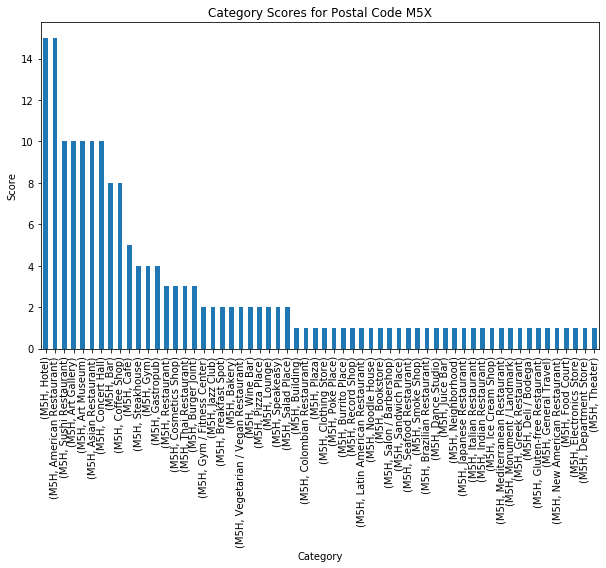

In [87]:
#create a bar plot of categories and scores
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

chk_gb3.plot(kind='bar', x='Category', figsize=(10, 6))

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Score') # add y-label to the plot
plt.title('Category Scores for Postal Code M5X') # add title to the plot

plt.show()

M5W

In [88]:
#plot
chk = df_top5.loc[df_top5['PostalCode'] == top5_list[4]]
chk_gb4 = chk.groupby(['PostalCode', 'Category'])['Score'].sum() #.sort_values('Score', ascending=False)
chk_gb4.head() #this is a series - pandas.core.series.Series

PostalCode  Category    
M5W         Antique Shop     0.0
            Art Gallery     20.0
            BBQ Joint        1.0
            Bagel Shop       1.0
            Bakery           2.0
Name: Score, dtype: float64

In [89]:
chk_gb4.sort_values(ascending=False, inplace=True)
chk_gb4.head()

PostalCode  Category          
M5W         Basketball Stadium    25.0
            Art Gallery           20.0
            Hotel                 15.0
            Coffee Shop           11.0
            Cocktail Bar           6.0
Name: Score, dtype: float64

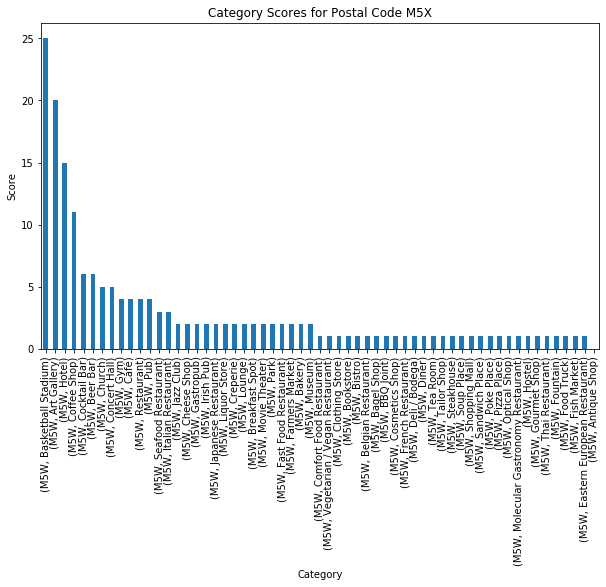

In [90]:
#create a bar plot of categories and scores
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

chk_gb4.plot(kind='bar', x='Category', figsize=(10, 6))

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Score') # add y-label to the plot
plt.title('Category Scores for Postal Code M5X') # add title to the plot

plt.show()

In [91]:
#for iteration plot work
df_top5.PostalCode.unique()

array(['M5H', 'M5J', 'M5K', 'M5W', 'M5X'], dtype=object)

#### We have the total scores and venue categories for each Postal Code (great). But what about crime?

In [92]:
#pull in data from the Toronto Police Open Data Portal (downloaded locally for this project). Website is http://data.torontopolice.on.ca/datasets/mci-2014-to-2018?geometry=-80.018%2C43.544%2C-78.168%2C43.891
toronto_crime = pd.read_csv('MCI_2014_to_2018.csv', header=0)
toronto_crime.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,ObjectId
0,-79.343094,43.668449,214,GO-20141948968,2014-04-24T11:29:00.000Z,2014-04-24T12:46:00.000Z,Commercial,1610,200,Robbery - Mugging,2014,April,24,114,Thursday,12,2014.0,April,24.0,114.0,Thursday,11,Robbery,D55,68,North Riverdale (68),43.668449,-79.343094,1
1,-79.507927,43.759285,215,GO-20141950728,2014-04-24T13:00:00.000Z,2014-04-24T15:58:00.000Z,House,2120,200,B&E,2014,April,24,114,Thursday,15,2014.0,April,24.0,114.0,Thursday,13,Break and Enter,D31,24,Black Creek (24),43.759285,-79.507927,2
2,-79.501663,43.697552,216,GO-20141956416,2014-04-25T13:20:00.000Z,2014-04-25T13:52:00.000Z,Apartment,1430,100,Assault,2014,April,25,115,Friday,13,2014.0,April,25.0,115.0,Friday,13,Assault,D12,30,Brookhaven-Amesbury (30),43.697552,-79.501663,3
3,-79.571510,43.721703,217,GO-20141956867,2014-04-24T17:00:00.000Z,2014-04-25T10:30:00.000Z,Outside,1430,100,Assault,2014,April,25,115,Friday,10,2014.0,April,24.0,114.0,Thursday,17,Assault,D23,4,Rexdale-Kipling (4),43.721703,-79.571510,4
4,-79.503487,43.663891,218,GO-20141957505,2014-04-25T16:00:00.000Z,2014-04-25T16:15:00.000Z,Apartment,1430,100,Assault,2014,April,25,115,Friday,16,2014.0,April,25.0,115.0,Friday,16,Assault,D11,114,Lambton Baby Point (114),43.663891,-79.503487,5


In [93]:
toronto_crime.shape

(167525, 29)

In [94]:
#check for duplicate event_unique_ids and delete duplicates
toronto_crime_scrub = toronto_crime.drop_duplicates(subset='event_unique_id', keep='first')
toronto_crime_scrub.shape

(145817, 29)

In [95]:
#check data types in the dataframe
toronto_crime_scrub.dtypes

X                      float64
Y                      float64
Index_                   int64
event_unique_id         object
occurrencedate          object
reporteddate            object
premisetype             object
ucr_code                 int64
ucr_ext                  int64
offence                 object
reportedyear             int64
reportedmonth           object
reportedday              int64
reporteddayofyear        int64
reporteddayofweek       object
reportedhour             int64
occurrenceyear         float64
occurrencemonth         object
occurrenceday          float64
occurrencedayofyear    float64
occurrencedayofweek     object
occurrencehour           int64
MCI                     object
Division                object
Hood_ID                  int64
Neighbourhood           object
Lat                    float64
Long                   float64
ObjectId                 int64
dtype: object

In [96]:
#check for number of nulls for each column
toronto_crime_scrub.isna().sum()

X                       0
Y                       0
Index_                  0
event_unique_id         0
occurrencedate          0
reporteddate            0
premisetype             0
ucr_code                0
ucr_ext                 0
offence                 0
reportedyear            0
reportedmonth           0
reportedday             0
reporteddayofyear       0
reporteddayofweek       0
reportedhour            0
occurrenceyear         40
occurrencemonth        40
occurrenceday          40
occurrencedayofyear    40
occurrencedayofweek    40
occurrencehour          0
MCI                     0
Division                0
Hood_ID                 0
Neighbourhood           0
Lat                     0
Long                    0
ObjectId                0
dtype: int64

In [97]:
#check the proportion of records that are missing
toronto_crime_scrub.isna().mean()

X                      0.000000
Y                      0.000000
Index_                 0.000000
event_unique_id        0.000000
occurrencedate         0.000000
reporteddate           0.000000
premisetype            0.000000
ucr_code               0.000000
ucr_ext                0.000000
offence                0.000000
reportedyear           0.000000
reportedmonth          0.000000
reportedday            0.000000
reporteddayofyear      0.000000
reporteddayofweek      0.000000
reportedhour           0.000000
occurrenceyear         0.000274
occurrencemonth        0.000274
occurrenceday          0.000274
occurrencedayofyear    0.000274
occurrencedayofweek    0.000274
occurrencehour         0.000000
MCI                    0.000000
Division               0.000000
Hood_ID                0.000000
Neighbourhood          0.000000
Lat                    0.000000
Long                   0.000000
ObjectId               0.000000
dtype: float64

#### We can see that missing records are less than 1% (0.03% to be exact) of the rows for columns occurrenceyear through occurrencedayofweek

In [98]:
#drop rows with missing values (as noted above) and check to see if performed as expected
toronto_crime_scrub.dropna(axis='rows', inplace=True)
toronto_crime_scrub.isna().mean()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


X                      0.0
Y                      0.0
Index_                 0.0
event_unique_id        0.0
occurrencedate         0.0
reporteddate           0.0
premisetype            0.0
ucr_code               0.0
ucr_ext                0.0
offence                0.0
reportedyear           0.0
reportedmonth          0.0
reportedday            0.0
reporteddayofyear      0.0
reporteddayofweek      0.0
reportedhour           0.0
occurrenceyear         0.0
occurrencemonth        0.0
occurrenceday          0.0
occurrencedayofyear    0.0
occurrencedayofweek    0.0
occurrencehour         0.0
MCI                    0.0
Division               0.0
Hood_ID                0.0
Neighbourhood          0.0
Lat                    0.0
Long                   0.0
ObjectId               0.0
dtype: float64

In [99]:
toronto_crime_scrub.shape

(145777, 29)

#### We see that the 40 rows have been deleted (confirmed)

In [100]:
toronto_crime_scrub.isna().sum()

X                      0
Y                      0
Index_                 0
event_unique_id        0
occurrencedate         0
reporteddate           0
premisetype            0
ucr_code               0
ucr_ext                0
offence                0
reportedyear           0
reportedmonth          0
reportedday            0
reporteddayofyear      0
reporteddayofweek      0
reportedhour           0
occurrenceyear         0
occurrencemonth        0
occurrenceday          0
occurrencedayofyear    0
occurrencedayofweek    0
occurrencehour         0
MCI                    0
Division               0
Hood_ID                0
Neighbourhood          0
Lat                    0
Long                   0
ObjectId               0
dtype: int64

In [101]:
#set occurrenceyear, occurrenceday and occurrencedayofyear columns to int
toronto_crime_scrub = toronto_crime_scrub.astype({'occurrenceyear': int, 'occurrenceday': int, 'occurrencedayofyear': int})
toronto_crime_scrub.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,ObjectId
0,-79.343094,43.668449,214,GO-20141948968,2014-04-24T11:29:00.000Z,2014-04-24T12:46:00.000Z,Commercial,1610,200,Robbery - Mugging,2014,April,24,114,Thursday,12,2014,April,24,114,Thursday,11,Robbery,D55,68,North Riverdale (68),43.668449,-79.343094,1
1,-79.507927,43.759285,215,GO-20141950728,2014-04-24T13:00:00.000Z,2014-04-24T15:58:00.000Z,House,2120,200,B&E,2014,April,24,114,Thursday,15,2014,April,24,114,Thursday,13,Break and Enter,D31,24,Black Creek (24),43.759285,-79.507927,2
2,-79.501663,43.697552,216,GO-20141956416,2014-04-25T13:20:00.000Z,2014-04-25T13:52:00.000Z,Apartment,1430,100,Assault,2014,April,25,115,Friday,13,2014,April,25,115,Friday,13,Assault,D12,30,Brookhaven-Amesbury (30),43.697552,-79.501663,3
3,-79.571510,43.721703,217,GO-20141956867,2014-04-24T17:00:00.000Z,2014-04-25T10:30:00.000Z,Outside,1430,100,Assault,2014,April,25,115,Friday,10,2014,April,24,114,Thursday,17,Assault,D23,4,Rexdale-Kipling (4),43.721703,-79.571510,4
4,-79.503487,43.663891,218,GO-20141957505,2014-04-25T16:00:00.000Z,2014-04-25T16:15:00.000Z,Apartment,1430,100,Assault,2014,April,25,115,Friday,16,2014,April,25,115,Friday,16,Assault,D11,114,Lambton Baby Point (114),43.663891,-79.503487,5


In [102]:
#toronto_crime_scrub.loc[df['occurrenceyear'].isin('NaN')]
temp_gb = toronto_crime_scrub.groupby('occurrenceyear')['occurrenceyear'].count()
temp_gb

occurrenceyear
2000       13
2001       10
2002        7
2003        8
2004        9
2005        8
2006        7
2007       16
2008       23
2009       28
2010       49
2011       66
2012      117
2013      452
2014    27829
2015    28045
2016    28274
2017    29746
2018    31070
Name: occurrenceyear, dtype: int64

#### Not a lot of data points prior to 2014. We'll focus on 2014-2018
#### Let's remove years prior to 2014.

In [103]:
#create dataframe of just years 2014 and greater
toronto_crime_scrub_2014plus = (toronto_crime_scrub.loc[toronto_crime_scrub['occurrenceyear'] >= 2014])
toronto_crime_scrub_2014plus.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,ObjectId
0,-79.343094,43.668449,214,GO-20141948968,2014-04-24T11:29:00.000Z,2014-04-24T12:46:00.000Z,Commercial,1610,200,Robbery - Mugging,2014,April,24,114,Thursday,12,2014,April,24,114,Thursday,11,Robbery,D55,68,North Riverdale (68),43.668449,-79.343094,1
1,-79.507927,43.759285,215,GO-20141950728,2014-04-24T13:00:00.000Z,2014-04-24T15:58:00.000Z,House,2120,200,B&E,2014,April,24,114,Thursday,15,2014,April,24,114,Thursday,13,Break and Enter,D31,24,Black Creek (24),43.759285,-79.507927,2
2,-79.501663,43.697552,216,GO-20141956416,2014-04-25T13:20:00.000Z,2014-04-25T13:52:00.000Z,Apartment,1430,100,Assault,2014,April,25,115,Friday,13,2014,April,25,115,Friday,13,Assault,D12,30,Brookhaven-Amesbury (30),43.697552,-79.501663,3
3,-79.571510,43.721703,217,GO-20141956867,2014-04-24T17:00:00.000Z,2014-04-25T10:30:00.000Z,Outside,1430,100,Assault,2014,April,25,115,Friday,10,2014,April,24,114,Thursday,17,Assault,D23,4,Rexdale-Kipling (4),43.721703,-79.571510,4
4,-79.503487,43.663891,218,GO-20141957505,2014-04-25T16:00:00.000Z,2014-04-25T16:15:00.000Z,Apartment,1430,100,Assault,2014,April,25,115,Friday,16,2014,April,25,115,Friday,16,Assault,D11,114,Lambton Baby Point (114),43.663891,-79.503487,5


In [104]:
#set scrub to this table
toronto_crime_scrub = toronto_crime_scrub_2014plus
toronto_crime_scrub.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,ObjectId
0,-79.343094,43.668449,214,GO-20141948968,2014-04-24T11:29:00.000Z,2014-04-24T12:46:00.000Z,Commercial,1610,200,Robbery - Mugging,2014,April,24,114,Thursday,12,2014,April,24,114,Thursday,11,Robbery,D55,68,North Riverdale (68),43.668449,-79.343094,1
1,-79.507927,43.759285,215,GO-20141950728,2014-04-24T13:00:00.000Z,2014-04-24T15:58:00.000Z,House,2120,200,B&E,2014,April,24,114,Thursday,15,2014,April,24,114,Thursday,13,Break and Enter,D31,24,Black Creek (24),43.759285,-79.507927,2
2,-79.501663,43.697552,216,GO-20141956416,2014-04-25T13:20:00.000Z,2014-04-25T13:52:00.000Z,Apartment,1430,100,Assault,2014,April,25,115,Friday,13,2014,April,25,115,Friday,13,Assault,D12,30,Brookhaven-Amesbury (30),43.697552,-79.501663,3
3,-79.571510,43.721703,217,GO-20141956867,2014-04-24T17:00:00.000Z,2014-04-25T10:30:00.000Z,Outside,1430,100,Assault,2014,April,25,115,Friday,10,2014,April,24,114,Thursday,17,Assault,D23,4,Rexdale-Kipling (4),43.721703,-79.571510,4
4,-79.503487,43.663891,218,GO-20141957505,2014-04-25T16:00:00.000Z,2014-04-25T16:15:00.000Z,Apartment,1430,100,Assault,2014,April,25,115,Friday,16,2014,April,25,115,Friday,16,Assault,D11,114,Lambton Baby Point (114),43.663891,-79.503487,5


In [105]:
#confirm occurrenceyears < 2014 were deleted
toronto_crime_scrub_gb_yr = pd.DataFrame(toronto_crime_scrub.groupby('occurrenceyear')['occurrenceyear'].count())
toronto_crime_scrub_gb_yr.rename({'occurrenceyear':'Number_of_Crimes'},axis=1, inplace=True) #rename count column to desired column name before resetting index
toronto_crime_scrub_gb_yr.reset_index(inplace=True) #create df index based on numeric index
toronto_crime_scrub_gb_yr.rename({'occurrenceyear':'Year_of_Occurrence'},axis=1, inplace=True) #rename count column to desired column name
toronto_crime_scrub_gb_yr

,Year_of_Occurrence,Number_of_Crimes
0,2014,27829
1,2015,28045
2,2016,28274
3,2017,29746
4,2018,31070


#### Great! It looks like we removed all occurrences < year 2014.
#### Now let's look at a barplot

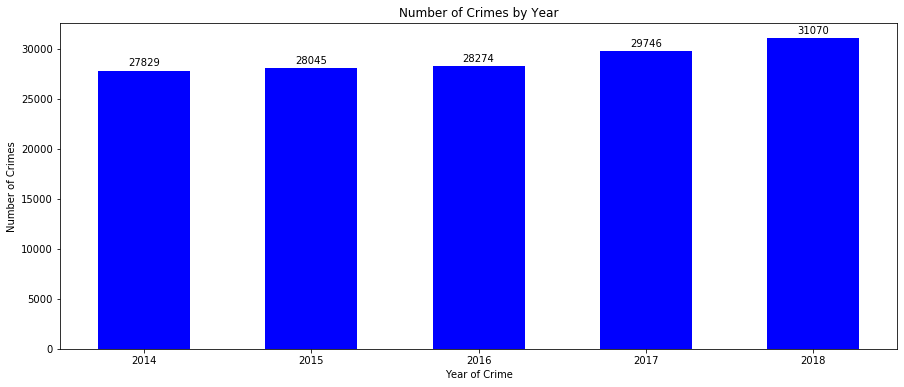

In [106]:
#NEED TO SET LEGEND
#NEED TO FORMAT NUMBERS ON BAR, Y-AXIS
#ax.legend() # rects1[0], 'Score' # rects1[0], ('Postal Code')
"""
========
Barchart - Number of Crimes
========

A bar plot with height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt

N = toronto_crime_scrub_gb_yr.shape[0] # or use: len(list(df_scores_gb_sorted_top20.PostalCode.values))
ind = np.arange(N)  # the x locations for the groups
width = 0.55       # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6)) #set figure size inside subplots
rects1 = ax.bar(ind, toronto_crime_scrub_gb_yr.Number_of_Crimes.values, width, color='b') #, figsize=(10, 6)


# add some text for labels, title and axes ticks
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Year of Crime')
ax.set_title('Number of Crimes by Year')
ax.set_xticks(ind) #ind + width / 2 for 2nd bar when plotting two bar subplots
ax.set_xticklabels(toronto_crime_scrub_gb_yr.Year_of_Occurrence.values) # set x-axis labels using the Postal Code column values


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, #1.05*height,
        '%d' % int(height),
        ha='center', va='bottom')

autolabel(rects1)

In [108]:
#create MCI groupby df
toronto_crime_gb_LatLong = pd.DataFrame(toronto_crime.groupby('MCI').agg({'MCI':'count',
                       'Lat':'mean',
                       'Long':'mean'})
                                               )
toronto_crime_gb_LatLong.rename({'MCI':'Count', 'Lat':'Avg_Lat', 'Long':'Avg_Long'}, axis=1, inplace=True)
toronto_crime_gb_LatLong

,Count,Avg_Lat,Avg_Long
MCI,,,
Assault,90878,43.705310,-79.388685
Auto Theft,18178,43.716975,-79.433585
Break and Enter,34911,43.708362,-79.388504
Robbery,18128,43.709389,-79.394446
Theft Over,5430,43.704193,-79.405737


In [119]:
#create MCI groupby df
toronto_crime_gb_LatLong_hood = pd.DataFrame(toronto_crime.groupby('Neighbourhood').agg({'Neighbourhood':'count',
                       'Lat':'mean',
                       'Long':'mean'})
                                               )
toronto_crime_gb_LatLong_hood.rename({'Lat':'Avg_Lat', 'Long':'Avg_Long', 'Neighbourhood':'Count'}, axis=1, inplace=True)
#df1.index.names = ['index']
toronto_crime_gb_LatLong_hood.index.names=['Neighborhood'] #rename index to Neighborhood
toronto_crime_gb_LatLong_hood.sort_values('Count', ascending=False, inplace=True)
toronto_crime_gb_LatLong_hood.head()

,Count,Avg_Lat,Avg_Long
Neighborhood,,,
Church-Yonge Corridor (75),6301,43.658719,-79.380419
Waterfront Communities-The Island (77),5674,43.644671,-79.388718
West Humber-Clairville (1),4338,43.720311,-79.598029
Moss Park (73),3609,43.656594,-79.370171
Bay Street Corridor (76),3564,43.654395,-79.384198


#### Let's perform k-means clustering on the toronto crimes. But we'll have to:
* Add one-hot for the MCI type
* Add back Neighborhood column
* Groupby Neighborhoods (MCIs in separate columns; sum MCI counts)
* Normalize the data
* Check for optimal cluster numbers
* Observe crime in top Neighborhoods

#### Remove categorical variables (and/or only select targeted columns for new df)

In [117]:
#remove categorical variables (and/or only select targeted columns for new df)
toronto_crime_scrub_4kmeans = toronto_crime_scrub[['MCI','Neighbourhood','Lat','Long']]
toronto_crime_scrub_4kmeans.head()

,MCI,Neighbourhood,Lat,Long
0,Robbery,North Riverdale (68),43.668449,-79.343094
1,Break and Enter,Black Creek (24),43.759285,-79.507927
2,Assault,Brookhaven-Amesbury (30),43.697552,-79.501663
3,Assault,Rexdale-Kipling (4),43.721703,-79.571510
4,Assault,Lambton Baby Point (114),43.663891,-79.503487


#### Add one-hot for the MCI type

In [120]:
# one hot encoding
toronto_crime_scrub_4kmeans_onehot = pd.get_dummies(toronto_crime_scrub_4kmeans[['MCI']], prefix="", prefix_sep="")

# add PostalCode column back to dataframe
toronto_crime_scrub_4kmeans_onehot['Neighborhood'] = toronto_crime_scrub['Neighbourhood'] 

# move Neighborhood column to the first column
fixed_columns = [toronto_crime_scrub_4kmeans_onehot.columns[-1]] + list(toronto_crime_scrub_4kmeans_onehot.columns[:-1])
toronto_crime_scrub_4kmeans_onehot = toronto_crime_scrub_4kmeans_onehot[fixed_columns]

toronto_crime_scrub_4kmeans_onehot.head()

,Neighborhood,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,North Riverdale (68),0,0,0,1,0
1,Black Creek (24),0,0,1,0,0
2,Brookhaven-Amesbury (30),1,0,0,0,0
3,Rexdale-Kipling (4),1,0,0,0,0
4,Lambton Baby Point (114),1,0,0,0,0


In [119]:
#WORKING FOR GROUPBY MCI'S AS NEXT STEP
#create MCI groupby df
toronto_crime_gb_LatLong_hood = pd.DataFrame(toronto_crime.groupby('Neighbourhood').agg({'Neighbourhood':'count',
                       'Lat':'mean',
                       'Long':'mean'})
                                               )
toronto_crime_gb_LatLong_hood.rename({'Lat':'Avg_Lat', 'Long':'Avg_Long', 'Neighbourhood':'Count'}, axis=1, inplace=True)
#df1.index.names = ['index']
toronto_crime_gb_LatLong_hood.index.names=['Neighborhood'] #rename index to Neighborhood
toronto_crime_gb_LatLong_hood.sort_values('Count', ascending=False, inplace=True)
toronto_crime_gb_LatLong_hood.head()

,Count,Avg_Lat,Avg_Long
Neighborhood,,,
Church-Yonge Corridor (75),6301,43.658719,-79.380419
Waterfront Communities-The Island (77),5674,43.644671,-79.388718
West Humber-Clairville (1),4338,43.720311,-79.598029
Moss Park (73),3609,43.656594,-79.370171
Bay Street Corridor (76),3564,43.654395,-79.384198


#### PLOT CRIMES BY NEIGHBORHOOD, OR AVG_LAT/LONG FOR EACH POSTALCODE???
#### PLOT CRIMES BY MCI TYPE (SUBPLOT, EITHER A MATRIX OF SEPARATE PLOTS OR SIDE-BY-SIDE BARS ON SAME PLOT???)

In [107]:
#create mean and counts
toronto_crime_gb = pd.DataFrame(toronto_crime.groupby('MCI').count()).reset_index()  #.sort_values(ascending=False).reset_index()
toronto_crime_gb

,MCI,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,Division,Hood_ID,Neighbourhood,Lat,Long,ObjectId
0,Assault,90878,90878,90878,90878,90878,90878,90878,90878,90878,90878,90878,90878,90878,90878,90878,90878,90837,90837,90837,90837,90837,90878,90878,90878,90878,90878,90878,90878
1,Auto Theft,18178,18178,18178,18178,18178,18178,18178,18178,18178,18178,18178,18178,18178,18178,18178,18178,18175,18175,18175,18175,18175,18178,18178,18178,18178,18178,18178,18178
2,Break and Enter,34911,34911,34911,34911,34911,34911,34911,34911,34911,34911,34911,34911,34911,34911,34911,34911,34910,34910,34910,34910,34910,34911,34911,34911,34911,34911,34911,34911
3,Robbery,18128,18128,18128,18128,18128,18128,18128,18128,18128,18128,18128,18128,18128,18128,18128,18128,18126,18126,18126,18126,18126,18128,18128,18128,18128,18128,18128,18128
4,Theft Over,5430,5430,5430,5430,5430,5430,5430,5430,5430,5430,5430,5430,5430,5430,5430,5430,5428,5428,5428,5428,5428,5430,5430,5430,5430,5430,5430,5430


In [110]:
print("There are {} Neighborhoods in the Toronto Crime analysis".format(toronto_crime_gb_LatLong_hood.shape[0]))

There are 141 Neighborhoods in the Toronto Crime analysis


#### After visually inspecting the location of the top five Postal Code scores, it was determined that they're located in the following Toronto PD Neighborhoods:
* Waterfront Communities-The Island (77)
* Bay Street Corridor (76)

Let's see the crime statistics in these areas.

#### Set MCI_NumFlag for plotting (number the MCIs 1-5)

In [111]:
#set MCI_NumFlag column
#if toronto_crime_scrub['MCI'] == 'Assault':
#   toronto_crime_scrub['MCI_NumFlag'] = 1

if toronto_crime_scrub['MCI'] == 'Assault':
    print('True')
else:
    print('False')

#else:
#   toronto_crime_scrub['MCI_NumFlag'] = 99

"""
elif toronto_crime_scrub['MCI'] == 'Auto Theft':
    toronto_crime_scrub['MCI_NumFlag'] = 2
elif toronto_crime_scrub['MCI'] == 'Break and Enter':
    toronto_crime_scrub['MCI_NumFlag'] = 3    
elif toronto_crime_scrub['MCI'] == 'Robbery':
    toronto_crime_scrub['MCI_NumFlag'] = 4
elif toronto_crime_scrub['MCI'] == 'Theft Over':
    toronto_crime_scrub['MCI_NumFlag'] = 5
"""

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
toronto_crime_scrub_gb_chk = pd.DataFrame(toronto_crime.groupby(['MCI','MCI_NumFlag']).agg({'Neighbourhood':'count',
                       'Lat':'mean',
                       'Long':'mean'})
toronto_crime_scrub_gb_chk

#### ---->>>>WORK ON PLOTTING CRIMES<<<<----

In [ ]:
# create map
"""
---->>>>WORK IN PROGRESS<<<<----
"""
#set inputs
latitude = 43.72
longitude = -79.4
n=toronto_crime_gb_LatLong.shape[0] #number of MCI types after groupby

toronto_crime_map1 = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(n) #number of 
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_crime_scrub.Lat, toronto_crime_scrub.Long, toronto_crime_scrub.MCI, toronto_venues_groupby_AddKmeansLabels['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_2)
       
toronto_crime_map1

In [ ]:
#EDIT TO PLOT CRIMES (inserted from DV0101EN-3-5-1)
#need to add initial lat, long?
# create map and display it

"""
---->>>>WORK IN PROGRESS<<<<----
toronto_crime_map1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# loop through the 100 crimes and add each to the map
for lat, lng, label in zip(toronto_crime_scrub.Lat, toronto_crime_scrub.Long, toronto_crime_scrub.MCI):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(toronto_crime_map1)

# show map
toronto_crime_map1
"""

#### ---->>>>PLOT AVG_LAT, AVG_LONG???<<<<----

#### STOP HERE

#### Let's get a sense of the types of crimes committed by year. But first, let's import the pandas_profiling libraries

In [ ]:
conda install -c conda-forge pandas-profiling #--yes needed?

In [ ]:
import pandas_profiling

In [106]:
pandas_profiling.ProfileReport(toronto_crime)


KeyboardInterrupt: 

* add toronto crime tables from article
* show NaN, counts by year, total crimes by year, total crimes by postal code
* add totals to end of bar (see matplotlib update)
* maybe add all 5 postal codes to crime chart (if able to connect postal codes)

In [ ]:
#plot categories and scores for each top 5 postal code
#for item in items:
    


#### Create  Postal Code - cluster label mapping

#### Next steps:
  * Check venue categories using for labels 0 and 1 to look for trend (total table, 0 label, and 1 label) - DONE for total, remaining pending
  * Check venue categories using for labels 0 and 1 to look for trend
  * Added venues scores and top 20. Now view categories per Postal Code with the highest scores
  * Also (on labels topic) look at >0 mean venues similar to end of 3-3-2
  * *-->>IN PROGRESS Found article on Toronto crime. Show the cluster "elbow." Check notes for number of cluster table
  * perform (kmeans, DBScan, HBScan)
  * DBScan clustering - python notes?? 
  * HBSCAN clustering using  (maybe )
  * Consider having a list of inspirational articles (links)
  **DONE - use 3-3-2 for onehot.groupby('Neighborhood').mean().reset_index(). show avgs but be aware of counts.  
  * DONE - Toronto crime. use top 25 pandas tricks on evaluating the data.
  * DONE - Plot the labels, clusters
  * DONE - then have to merge labels with original df (join on postal code)
  * DONE - kmeans clustering - start from pre-processing section of DP0701EN-3-3-1-Clustering-k-means-py-v1.0. do one-hot analysis
  * DONE - copy p3 until analyze number of venues. keep all venues in and plot clusters for neighborhoods 
  * DONE - get list of categories
  * DONE - download data from Foursquare
  * DONE / CHECKED - after onehot, show frequencies of venues?
  * NOTED - get avgs beware of low counts for  groupby on clusters (for categories, venues)
  * CNCL - get ratings of venues/categories - might not need
  * CNCL - determine good/neutral/bad categories - assign point ratings
  * N/A - Read Amherst list of great areas


In [ ]:
#create a pivot 
#TRYING TO PLOT TOTAL SCORE, POSTAL CODE AND CLUSTER LABELS BY PIVOT TABLE (AFTER FILTERING FOR TOP5 POSTAL CODE)
#set top 5 list
#df_scores_gb_sorted_top5['PostalCode']==df_toronto_venues_labeled2['PostalCode']
#table = pd.pivot_table(df_top5,
#                      values='Score',
#                      index=['Cluster Labels', 'PostalCode', 'Venue Category'],
#                      aggfunc={'Score': np.sum})
#table

In [246]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

NameError: name 'neighborhoods_venues_sorted' is not defined

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [ ]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [44]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4,Sandwich Place,Discount Store,Coffee Shop,Yoga Studio,Clothing Store,Supplement Shop,Gym,Donut Shop,Shopping Mall,Steakhouse
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Cocktail Bar,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Bakery,Bubble Tea Shop,Spa,Dumpling Restaurant,Ice Cream Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Mobile Phone Shop,Bakery,Grocery Store,Coffee Shop,Mexican Restaurant,Liquor Store,Latin American Restaurant,New American Restaurant,Park
3,Manhattan,Inwood,40.867684,-73.921210,4,Mexican Restaurant,Café,Lounge,Pizza Place,Park,Bakery,Caribbean Restaurant,Chinese Restaurant,Restaurant,Frozen Yogurt Shop
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,Coffee Shop,Mexican Restaurant,Pizza Place,Café,Yoga Studio,Indian Restaurant,Sushi Restaurant,Sandwich Place,Deli / Bodega,Liquor Store
